# Attention Head Ablation: Impact on Model Performance

This notebook performs an ablation study on the number of attention heads in vision transformer models, specifically analyzing DINOv2-B-14 with CLS+AP token selection from all 24 layers.

The analysis compares model performance across different numbers of attention heads (1, 8, and 24) to understand how attention mechanism complexity affects downstream task performance.

**Output**: A multi-panel bar chart displaying test balanced accuracy for each dataset across different numbers of attention heads. Each panel represents a different dataset, with bars colored by the number of heads used, enabling direct comparison of how attention head count impacts performance across various vision tasks.

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sys.path.append('..')
sys.path.append('../..')

from constants import BASE_PATH_PROJECT, ds_info_file, FOLDER_SUBSTRING
from helper import set_ylims_with_margin, load_ds_info, save_or_show, init_plotting_params

In [2]:
init_plotting_params()

{
  "agg.path.chunksize": 0,
  "axes.labelsize": 13.0,
  "axes.titlesize": 14.0,
  "axes3d.trackballsize": 0.667,
  "boxplot.flierprops.markersize": 6.0,
  "boxplot.meanprops.markersize": 6.0,
  "errorbar.capsize": 0.0,
  "figure.figsize": [
    6.4,
    4.8
  ],
  "figure.labelsize": "large",
  "figure.titlesize": "large",
  "font.cursive": [
    "Apple Chancery",
    "Textile",
    "Zapf Chancery",
    "Sand",
    "Script MT",
    "Felipa",
    "Comic Neue",
    "Comic Sans MS",
    "cursive"
  ],
  "font.family": [
    "sans-serif"
  ],
  "font.fantasy": [
    "Chicago",
    "Charcoal",
    "Impact",
    "Western",
    "xkcd script",
    "fantasy"
  ],
  "font.monospace": [
    "DejaVu Sans Mono",
    "Bitstream Vera Sans Mono",
    "Computer Modern Typewriter",
    "Andale Mono",
    "Nimbus Mono L",
    "Courier New",
    "Courier",
    "Fixed",
    "Terminal",
    "monospace"
  ],
  "font.sans-serif": [
    "DejaVu Sans",
    "Bitstream Vera Sans",
    "Computer Modern Sans Serif

In [3]:
ds_info = load_ds_info(ds_info_file)

In [ ]:
project_path = BASE_PATH_PROJECT / f"results_{FOLDER_SUBSTRING}_exp"
storing_path = project_path / "plots" / "appendix_nr_heads"

SAVE = 'both'
if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

In [5]:
attn_probe_res = pd.read_pickle(BASE_PATH_PROJECT / "results/aggregated/comb_attn_wo_clustering_results.pkl")
single_model_res = pd.read_pickle(BASE_PATH_PROJECT / "results/aggregated/sing_linear_results.pkl")

In [6]:
single_model_res = single_model_res[single_model_res['model_ids'] == '["dinov2-vit-base-p14_cls@norm"]'].copy().reset_index(drop=True)
single_model_res = single_model_res.set_index('dataset')

In [7]:
dinov2_runs = attn_probe_res[attn_probe_res['base_model'] == 'dinov2-vit-base-p14']
dinov2_runs = dinov2_runs[dinov2_runs['layer_types']=="cls+avg_pool"]
dinov2_runs = dinov2_runs[dinov2_runs['nr_layers']==24]
dinov2_runs = dinov2_runs[dinov2_runs['num_heads']!=48]
dinov2_runs = dinov2_runs[~dinov2_runs['dataset'].isin(["wds/imagenet1k", 'imagenet-subset-50k'])].copy().reset_index(drop=True)

In [8]:
metric_cols = ['train_lp_bal_acc1', 'train_lp_bal_acc5', 'test_lp_bal_acc1', 'test_lp_bal_acc5']

In [9]:
dinov2_runs['scaled_test_lp_bal_acc1'] = dinov2_runs.groupby('dataset')['test_lp_bal_acc1'].apply(lambda x : x - x.min()).reset_index().sort_values('level_1').reset_index(drop=True)['test_lp_bal_acc1']

stored image.


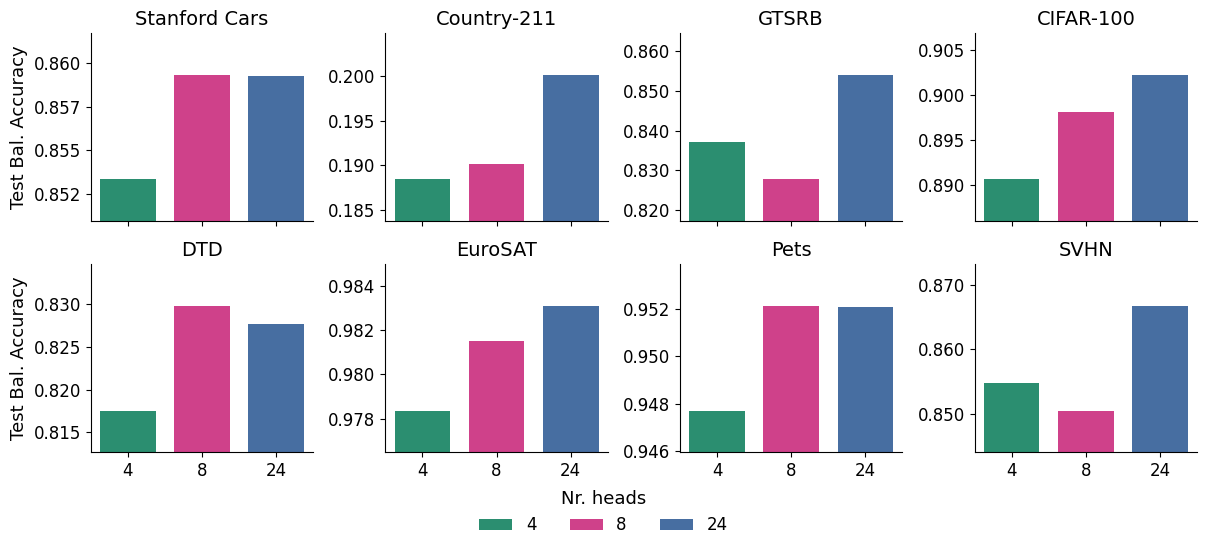

In [10]:
g = sns.catplot(
    dinov2_runs.sort_values("dataset"),
    x='num_heads',
    y='test_lp_bal_acc1',
    hue='num_heads',
    col='dataset',
    kind='bar',
    width=0.75,
    height=2.5,
    aspect=1.1,
    col_wrap=4,
    sharey=False,
    palette=sns.color_palette("Dark2")[0:1] + sns.color_palette("Dark2")[3:4]  + sns.color_palette("Accent")[4:5] 
)
g.set_titles("{col_name}")
g.map_dataframe(set_ylims_with_margin, metric='test_lp_bal_acc1', margin_percent=0.4)
g.set_axis_labels('', 'Test Bal. Accuracy')
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:.3f}'))
    ax.set_title(ds_info.loc[ax.get_title().replace("/", "_"), 'name'])

sns.move_legend(g, loc="upper center", bbox_to_anchor=(0.5,0.04), title="Nr. heads", ncols=3)
g.fig.tight_layout()

fn = storing_path / f'perf_per_nr_heads_v2.pdf'
save_or_show(g.fig, fn, SAVE)